# Imports

In [21]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Parameters

In [22]:
N_EPOCHS = 300
BATCH_SIZE = 16
DATASET_SIZE = 292
TRAIN_DATA_SIZE = 96
LATENT_DIM = 128

# Data importing and pre-processing

In [23]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(DATASET_SIZE, 64, 64, 1)

x_real_train, x_real_test = train_test_split(df, test_size=0.2)


normalize dataset data into range of sigmoid [0,1], and put into batches

In [24]:
x_real_train = x_real_train.astype('float32')
x_real_train /=255


training_data = tf.data.Dataset.from_tensor_slices(x_real_train).shuffle(TRAIN_DATA_SIZE).batch(BATCH_SIZE)

Visualise example from dataset

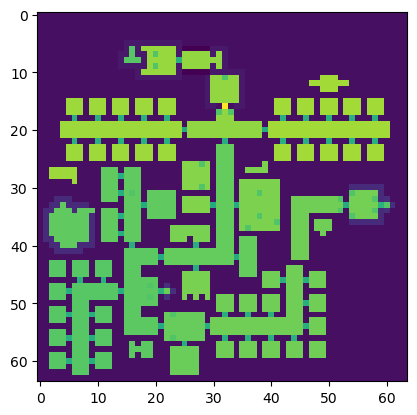

In [25]:
plt.imshow(df[0])

# Generator Model

Create points in latent space to be fed into generator

In [26]:
def generate_generator_input(no_of_maps):
    input = tf.random.normal(shape=(no_of_maps, LATENT_DIM))
    
    return input

In [27]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(LATENT_DIM*8*8, input_shape=(LATENT_DIM,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,LATENT_DIM)))


    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    


    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=5, padding="same"))
    model.add(Activation("sigmoid"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [28]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same", input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    

    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    '''
    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    '''
    
    model.add(Dense(100, activation='relu'))
    #model.add(Activation='relu')
    
    # output layer
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model
    

Create the models from the functions

In [29]:
gen_model = make_generator()

disc_model = make_discriminator()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 batch_normalization_4 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 128)       262144    
 Transpose)                                                      
                                                                 
 batch_normalization_5 (Bat  (None, 16, 16, 128)      

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

## Loss and Optimizers

In [30]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, taken from: https://www.tensorflow.org/tutorials/generative/dcgan

In [31]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [32]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [33]:
gen_optimizer = Adam(learning_rate =0.0001, beta_1=0.5)
disc_optimizer = Adam(learning_rate =0.0001, beta_1=0.5)

Discriminator accuracy

In [34]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output[0] >=0:
        
        if fake_output[0] <0:
            accuracy = (real_output[0] + fake_output[0]) / (real_output[0] + fake_output[0])
        else:
            accuracy = real_output[0]/ (real_output[0] + fake_output[0])
    elif fake_output[0] <0:
        accuracy = fake_output[0] / (real_output[0] + fake_output[0])
    else:
        accuracy = 0/ (real_output[0] + fake_output[0])
    
    return accuracy

## Training

Training step

In [35]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input(BATCH_SIZE)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [36]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    
    img_seed = generate_generator_input(1)

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        disc_accuracies_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / TRAIN_DATA_SIZE
        avg_disc_loss = sum(disc_losses_for_epoch) / TRAIN_DATA_SIZE

        avg_disc_accuracy = sum(disc_accuracies_for_epoch) / TRAIN_DATA_SIZE

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        disc_accuracies.append(avg_disc_accuracy)

        print("Gen loss = " + str(avg_gen_loss))
        print("Disc loss = " + str(avg_disc_loss))

        print("Disc accuracy = " + str(avg_disc_accuracy))
# generate and show a map after 10 epochs

        if epoch % 10 == 0:
            
            generated_map = gen_model(img_seed, training=False)
            generated_map *= 255
            generated_map = generated_map.numpy()
            generated_map.reshape(64,64)
            generated_map = np.round(generated_map,0)
            generated_map = generated_map.tolist()
            plt.imshow(generated_map[0])
            plt.show()
    
    input_for_map_after_training = generate_generator_input(1)
    generated_map = gen_model(input_for_map_after_training, training=False)

    

    return gen_losses, disc_losses, generated_map, disc_accuracies


Train GAN

epoch = 0
generated map shape(16, 64, 64, 1)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


generated map shape(16, 64, 64, 1)
generated map shape(16, 64, 64, 1)
Gen loss = tf.Tensor(0.091201305, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2174586, shape=(), dtype=float32)
Disc accuracy = 0.0


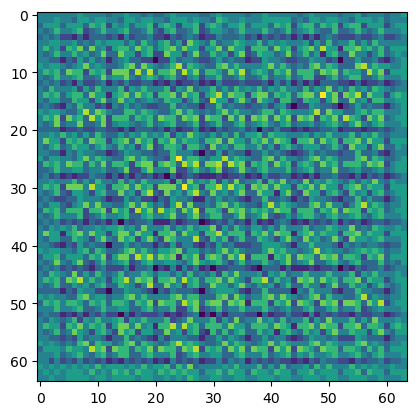

epoch = 1
Gen loss = tf.Tensor(0.1142141, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19614457, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 2
Gen loss = tf.Tensor(0.12413484, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18529963, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 3
Gen loss = tf.Tensor(0.11773593, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18762952, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 4
Gen loss = tf.Tensor(0.10001478, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21706355, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 5
Gen loss = tf.Tensor(0.119980425, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21753182, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 6
Gen loss = tf.Tensor(0.13786949, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18493195, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 7
Gen loss = tf.Tensor(0.14210485, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15382266, shape=(), dtype=

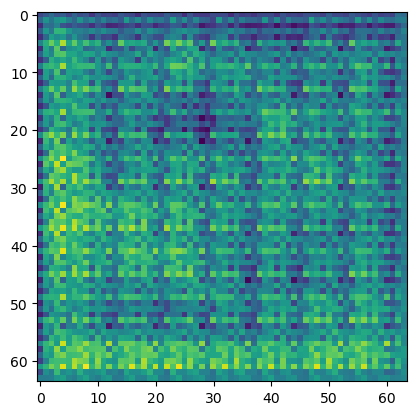

epoch = 11
Gen loss = tf.Tensor(0.116424225, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22459112, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 12
Gen loss = tf.Tensor(0.109189995, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.27463052, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 13
Gen loss = tf.Tensor(0.11208754, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.26470077, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 14
Gen loss = tf.Tensor(0.12789004, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20495206, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 15
Gen loss = tf.Tensor(0.11433816, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19913471, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 16
Gen loss = tf.Tensor(0.09591048, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23332475, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 17
Gen loss = tf.Tensor(0.09304076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23365445, shape=(

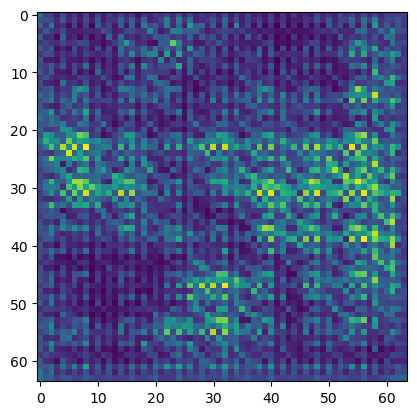

epoch = 21
Gen loss = tf.Tensor(0.10102224, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24752252, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 22
Gen loss = tf.Tensor(0.093663745, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2514521, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 23
Gen loss = tf.Tensor(0.10895636, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23566024, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 24
Gen loss = tf.Tensor(0.09811458, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24993609, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 25
Gen loss = tf.Tensor(0.09974892, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24944793, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 26
Gen loss = tf.Tensor(0.08847248, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.25834176, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 27
Gen loss = tf.Tensor(0.09169814, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.25694063, shape=(),

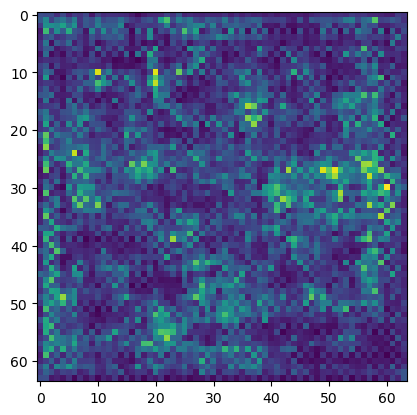

epoch = 31
Gen loss = tf.Tensor(0.086817384, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.26040027, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 32
Gen loss = tf.Tensor(0.094508745, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2536541, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 33
Gen loss = tf.Tensor(0.09133562, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.25405806, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 34
Gen loss = tf.Tensor(0.0868432, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2607916, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 35
Gen loss = tf.Tensor(0.093131326, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2517118, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 36
Gen loss = tf.Tensor(0.09474311, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2504762, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 37
Gen loss = tf.Tensor(0.09404274, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.25484478, shape=(), d

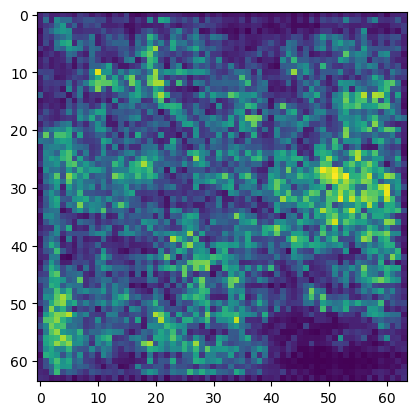

epoch = 41
Gen loss = tf.Tensor(0.09603319, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.249146, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 42
Gen loss = tf.Tensor(0.09970639, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24239999, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 43
Gen loss = tf.Tensor(0.098449506, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24298741, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 44
Gen loss = tf.Tensor(0.097471856, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24503803, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 45
Gen loss = tf.Tensor(0.09847809, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24157293, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 46
Gen loss = tf.Tensor(0.10017738, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24167198, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 47
Gen loss = tf.Tensor(0.09991357, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24020219, shape=(),

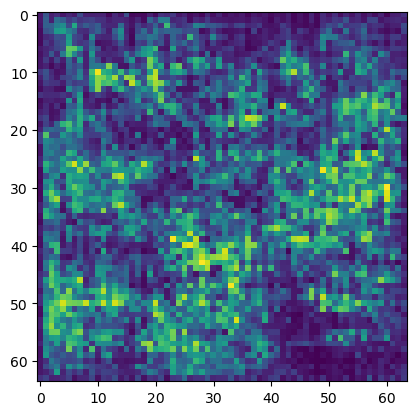

epoch = 51
Gen loss = tf.Tensor(0.10015443, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2405291, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 52
Gen loss = tf.Tensor(0.10054746, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23829259, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 53
Gen loss = tf.Tensor(0.10138142, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23680003, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 54
Gen loss = tf.Tensor(0.101721376, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23544724, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 55
Gen loss = tf.Tensor(0.101468354, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23660399, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 56
Gen loss = tf.Tensor(0.10083333, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2367811, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 57
Gen loss = tf.Tensor(0.10269126, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23378289, shape=(),

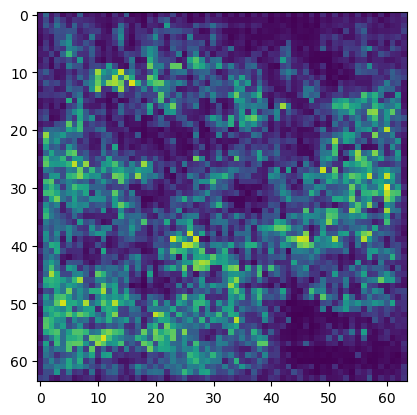

epoch = 61
Gen loss = tf.Tensor(0.10235423, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2323729, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 62
Gen loss = tf.Tensor(0.105160594, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22841679, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 63
Gen loss = tf.Tensor(0.105422415, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22817719, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 64
Gen loss = tf.Tensor(0.10568606, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22616471, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 65
Gen loss = tf.Tensor(0.10521545, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2281519, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 66
Gen loss = tf.Tensor(0.10598079, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22695093, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 67
Gen loss = tf.Tensor(0.10607982, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22777891, shape=(),

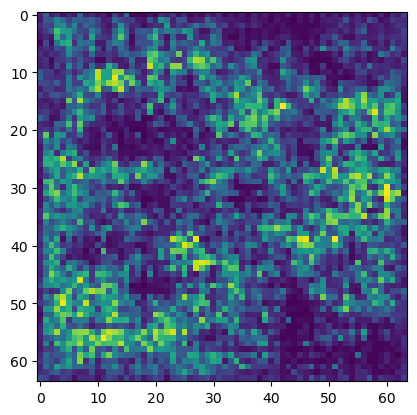

epoch = 71
Gen loss = tf.Tensor(0.106054194, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22603714, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 72
Gen loss = tf.Tensor(0.10696828, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22553413, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 73
Gen loss = tf.Tensor(0.10607361, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22642605, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 74
Gen loss = tf.Tensor(0.10674167, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22438818, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 75
Gen loss = tf.Tensor(0.10738904, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22541583, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 76
Gen loss = tf.Tensor(0.10640627, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2251547, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 77
Gen loss = tf.Tensor(0.10713962, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22362661, shape=(),

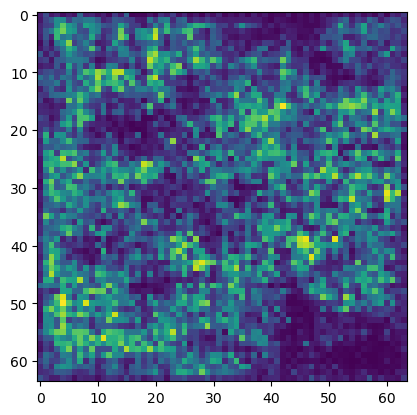

epoch = 81
Gen loss = tf.Tensor(0.10681483, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22245896, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 82
Gen loss = tf.Tensor(0.10682282, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2231731, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 83
Gen loss = tf.Tensor(0.10646535, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2220099, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 84
Gen loss = tf.Tensor(0.107259534, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2223785, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 85
Gen loss = tf.Tensor(0.108373374, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22115694, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 86
Gen loss = tf.Tensor(0.10802119, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22077598, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 87
Gen loss = tf.Tensor(0.106344074, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22172354, shape=(),

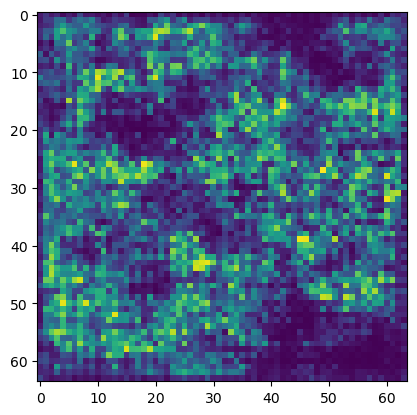

epoch = 91
Gen loss = tf.Tensor(0.10691327, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21912895, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 92
Gen loss = tf.Tensor(0.10930922, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22161227, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 93
Gen loss = tf.Tensor(0.10949942, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21968347, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 94
Gen loss = tf.Tensor(0.1059824, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2189099, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 95
Gen loss = tf.Tensor(0.107284576, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22123848, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 96
Gen loss = tf.Tensor(0.10831255, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21840763, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 97
Gen loss = tf.Tensor(0.10807406, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21843286, shape=(), 

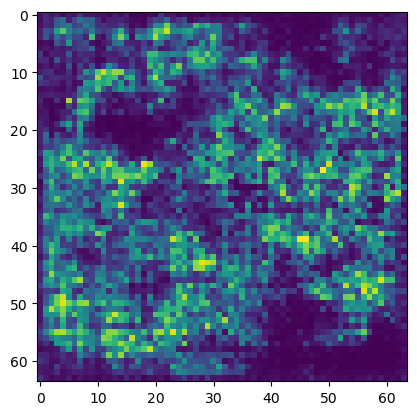

epoch = 101
Gen loss = tf.Tensor(0.10543501, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21958132, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 102
Gen loss = tf.Tensor(0.10779808, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21829939, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 103
Gen loss = tf.Tensor(0.110249154, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21629651, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 104
Gen loss = tf.Tensor(0.106458455, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21901448, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 105
Gen loss = tf.Tensor(0.10754035, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21710186, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 106
Gen loss = tf.Tensor(0.110128075, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21778105, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 107
Gen loss = tf.Tensor(0.10833368, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21717209,

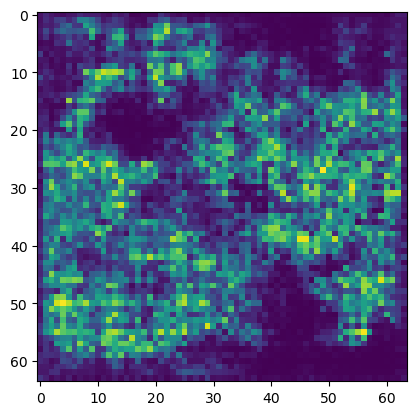

epoch = 111
Gen loss = tf.Tensor(0.10976303, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21769321, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 112
Gen loss = tf.Tensor(0.1078816, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2158822, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 113
Gen loss = tf.Tensor(0.108595245, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21549106, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 114
Gen loss = tf.Tensor(0.114147745, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21583079, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 115
Gen loss = tf.Tensor(0.10797712, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21611635, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 116
Gen loss = tf.Tensor(0.10787477, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21486646, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 117
Gen loss = tf.Tensor(0.11259031, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21365298, sh

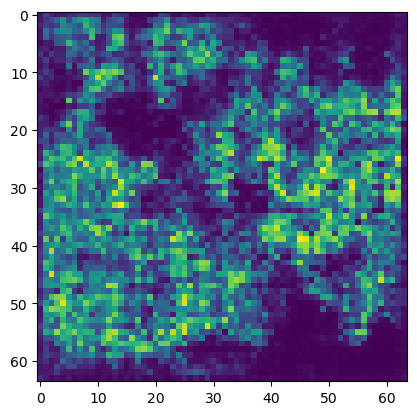

epoch = 121
Gen loss = tf.Tensor(0.110198654, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21443225, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 122
Gen loss = tf.Tensor(0.10783734, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21429265, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 123
Gen loss = tf.Tensor(0.11214741, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2146492, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 124
Gen loss = tf.Tensor(0.11187783, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21332413, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 125
Gen loss = tf.Tensor(0.10986645, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21363223, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 126
Gen loss = tf.Tensor(0.11022212, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21468253, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 127
Gen loss = tf.Tensor(0.10753878, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21344285, sh

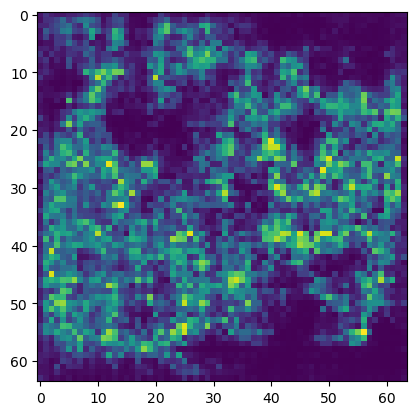

epoch = 131
Gen loss = tf.Tensor(0.11111028, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21286595, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 132
Gen loss = tf.Tensor(0.1076963, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21287441, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 133
Gen loss = tf.Tensor(0.11011639, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21277566, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 134
Gen loss = tf.Tensor(0.11235586, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21080612, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 135
Gen loss = tf.Tensor(0.10796102, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21126842, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 136
Gen loss = tf.Tensor(0.110860735, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21303654, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 137
Gen loss = tf.Tensor(0.112620465, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21124892, s

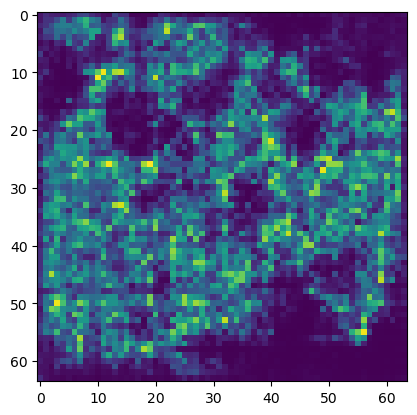

epoch = 141
Gen loss = tf.Tensor(0.10744225, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21113563, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 142
Gen loss = tf.Tensor(0.11326933, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21073651, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 143
Gen loss = tf.Tensor(0.12363101, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21062766, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 144
Gen loss = tf.Tensor(0.10885201, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.209682, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 145
Gen loss = tf.Tensor(0.11413532, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2116607, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 146
Gen loss = tf.Tensor(0.11791378, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21062736, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 147
Gen loss = tf.Tensor(0.11180825, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20576167, shape

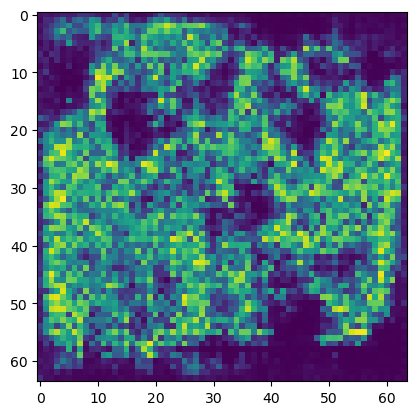

epoch = 151
Gen loss = tf.Tensor(0.11730972, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2127942, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 152
Gen loss = tf.Tensor(0.115317665, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20867558, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 153
Gen loss = tf.Tensor(0.11302995, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20872875, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 154
Gen loss = tf.Tensor(0.11643801, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.208934, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 155
Gen loss = tf.Tensor(0.10481867, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20870192, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 156
Gen loss = tf.Tensor(0.11711987, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20924033, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 157
Gen loss = tf.Tensor(0.11198551, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20806973, shap

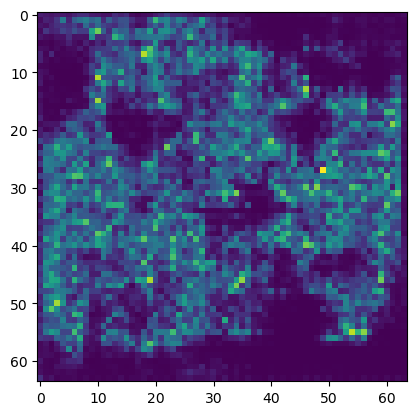

epoch = 161
Gen loss = tf.Tensor(0.109992266, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20885944, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 162
Gen loss = tf.Tensor(0.10590459, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20990658, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 163
Gen loss = tf.Tensor(0.105177976, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.208004, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 164
Gen loss = tf.Tensor(0.110810585, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21367264, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 165
Gen loss = tf.Tensor(0.108881555, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20935987, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 166
Gen loss = tf.Tensor(0.10647217, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2089327, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 167
Gen loss = tf.Tensor(0.11457387, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20866235, s

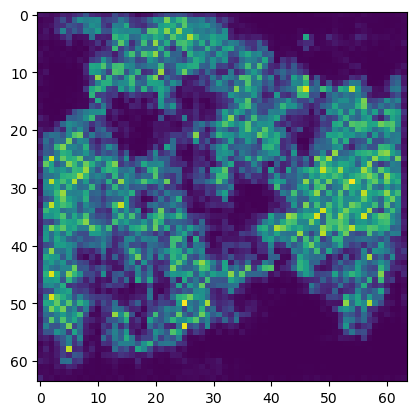

epoch = 171
Gen loss = tf.Tensor(0.11634324, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21068728, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 172
Gen loss = tf.Tensor(0.117150106, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20778517, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 173
Gen loss = tf.Tensor(0.115436666, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20457524, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 174
Gen loss = tf.Tensor(0.1170837, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20673685, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 175
Gen loss = tf.Tensor(0.11120658, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20361708, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 176
Gen loss = tf.Tensor(0.11817033, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20867896, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 177
Gen loss = tf.Tensor(0.11283138, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20192067, s

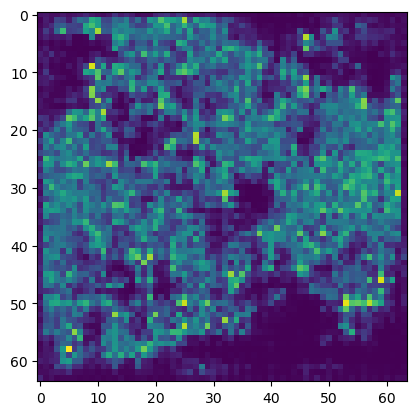

epoch = 181
Gen loss = tf.Tensor(0.10932636, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20812775, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 182
Gen loss = tf.Tensor(0.1164586, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20414339, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 183
Gen loss = tf.Tensor(0.109867096, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20793174, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 184
Gen loss = tf.Tensor(0.11576161, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20482732, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 185
Gen loss = tf.Tensor(0.11086931, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20778787, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 186
Gen loss = tf.Tensor(0.11673216, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2058161, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 187
Gen loss = tf.Tensor(0.11658635, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20493191, sha

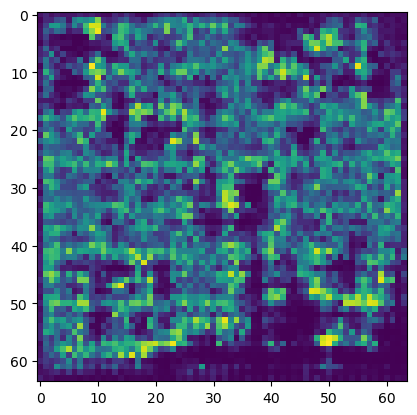

epoch = 191
Gen loss = tf.Tensor(0.116502255, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20184736, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 192
Gen loss = tf.Tensor(0.12368294, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20288806, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 193
Gen loss = tf.Tensor(0.110744424, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20138012, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 194
Gen loss = tf.Tensor(0.115830146, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20392995, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 195
Gen loss = tf.Tensor(0.11950656, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2050391, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 196
Gen loss = tf.Tensor(0.11373418, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20260404, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 197
Gen loss = tf.Tensor(0.116803646, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2047751, 

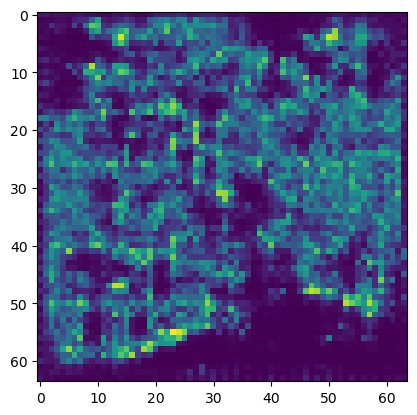

epoch = 201
Gen loss = tf.Tensor(0.114916496, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20408238, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 202
Gen loss = tf.Tensor(0.11626062, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20173456, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 203
Gen loss = tf.Tensor(0.116451025, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20247956, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 204
Gen loss = tf.Tensor(0.11721581, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20169693, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 205
Gen loss = tf.Tensor(0.11559719, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20233501, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 206
Gen loss = tf.Tensor(0.115816474, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20143588, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 207
Gen loss = tf.Tensor(0.11892766, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20340264,

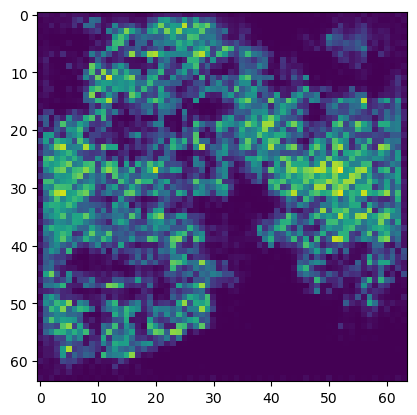

epoch = 211
Gen loss = tf.Tensor(0.12202241, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1966982, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 212
Gen loss = tf.Tensor(0.13242403, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1848195, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 213
Gen loss = tf.Tensor(0.16531575, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16605683, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 214
Gen loss = tf.Tensor(0.12248907, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18438464, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 215
Gen loss = tf.Tensor(0.16345347, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14975154, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 216
Gen loss = tf.Tensor(0.14206056, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20602445, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 217
Gen loss = tf.Tensor(0.15925081, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16930868, shap

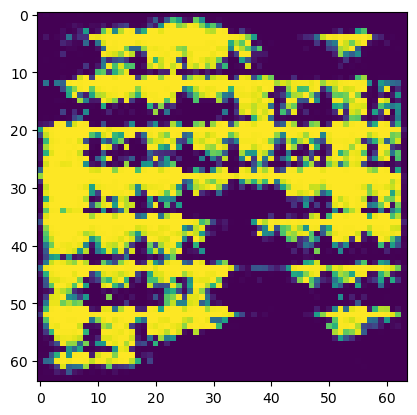

epoch = 221
Gen loss = tf.Tensor(0.20296918, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1272964, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 222
Gen loss = tf.Tensor(0.1542338, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16462518, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 223
Gen loss = tf.Tensor(0.14698547, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1652664, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 224
Gen loss = tf.Tensor(0.14705716, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16368753, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 225
Gen loss = tf.Tensor(0.1396709, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18072136, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 226
Gen loss = tf.Tensor(0.16288023, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15960889, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 227
Gen loss = tf.Tensor(0.16255313, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14044099, shape=

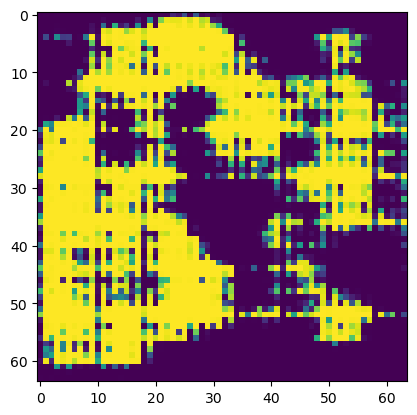

epoch = 231
Gen loss = tf.Tensor(0.154813, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17382027, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 232
Gen loss = tf.Tensor(0.15016796, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1737554, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 233
Gen loss = tf.Tensor(0.16707784, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14743964, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 234
Gen loss = tf.Tensor(0.20451993, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11661858, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 235
Gen loss = tf.Tensor(0.16616608, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14117113, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 236
Gen loss = tf.Tensor(0.24389899, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08591333, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 237
Gen loss = tf.Tensor(0.23365939, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09360864, shape

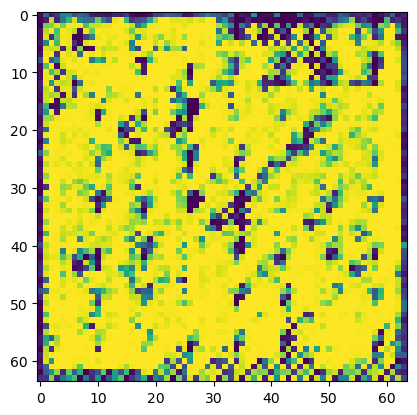

epoch = 241
Gen loss = tf.Tensor(0.17267151, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13408943, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 242
Gen loss = tf.Tensor(0.1856228, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13633193, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 243
Gen loss = tf.Tensor(0.16963768, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15325211, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 244
Gen loss = tf.Tensor(0.15748547, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16544648, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 245
Gen loss = tf.Tensor(0.18377537, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1268415, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 246
Gen loss = tf.Tensor(0.16672705, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13891126, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 247
Gen loss = tf.Tensor(0.17475326, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13918574, shap

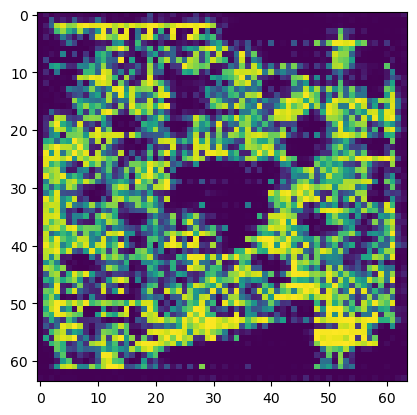

epoch = 251
Gen loss = tf.Tensor(0.15448071, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15692432, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 252
Gen loss = tf.Tensor(0.17059033, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14395425, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 253
Gen loss = tf.Tensor(0.16506507, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16229853, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 254
Gen loss = tf.Tensor(0.18065159, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15617841, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 255
Gen loss = tf.Tensor(0.15580721, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15834273, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 256
Gen loss = tf.Tensor(0.16021076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14838937, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 257
Gen loss = tf.Tensor(0.17777419, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13946755, sh

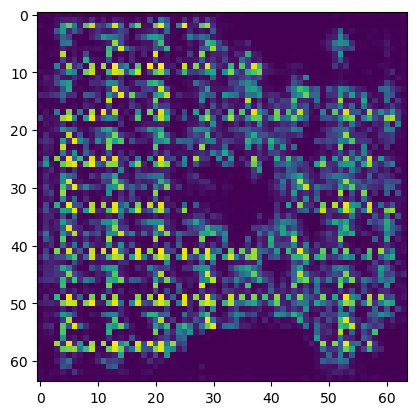

epoch = 261
Gen loss = tf.Tensor(0.09550769, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22277586, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 262
Gen loss = tf.Tensor(0.06911973, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21622227, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 263
Gen loss = tf.Tensor(0.09704369, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17836134, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 264
Gen loss = tf.Tensor(0.12034762, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17874563, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 265
Gen loss = tf.Tensor(0.1271293, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16646422, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 266
Gen loss = tf.Tensor(0.110366195, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21533245, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 267
Gen loss = tf.Tensor(0.11606874, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19848908, sh

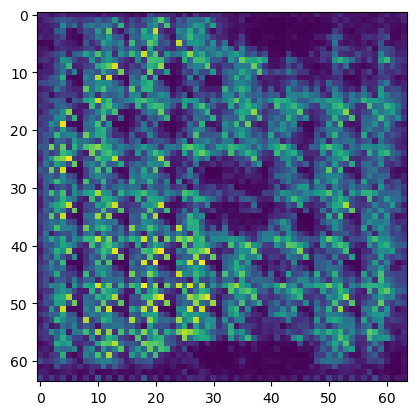

epoch = 271
Gen loss = tf.Tensor(0.1469493, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16748005, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 272
Gen loss = tf.Tensor(0.13792531, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17952263, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 273
Gen loss = tf.Tensor(0.14244212, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17033224, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 274
Gen loss = tf.Tensor(0.19566976, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1263243, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 275
Gen loss = tf.Tensor(0.1793154, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16316469, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 276
Gen loss = tf.Tensor(0.16476546, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15148969, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 277
Gen loss = tf.Tensor(0.1485386, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15561302, shape=

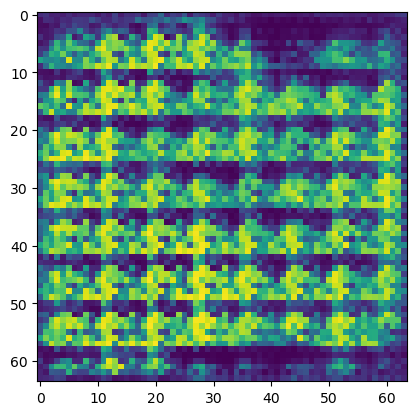

epoch = 281
Gen loss = tf.Tensor(0.22703344, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10704427, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 282
Gen loss = tf.Tensor(0.20614485, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.12641211, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 283
Gen loss = tf.Tensor(0.1726885, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13507557, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 284
Gen loss = tf.Tensor(0.20225973, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10977945, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 285
Gen loss = tf.Tensor(0.24232544, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08481216, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 286
Gen loss = tf.Tensor(0.2734028, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.067438684, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 287
Gen loss = tf.Tensor(0.22171617, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10570077, sha

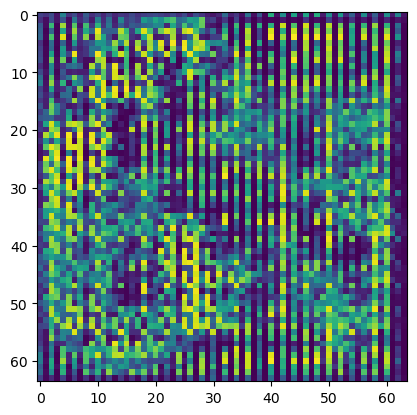

epoch = 291
Gen loss = tf.Tensor(0.20681964, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11274647, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 292
Gen loss = tf.Tensor(0.19013512, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14679217, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 293
Gen loss = tf.Tensor(0.16735536, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1668259, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 294
Gen loss = tf.Tensor(0.15092729, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16916336, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 295
Gen loss = tf.Tensor(0.1413192, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18028623, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 296
Gen loss = tf.Tensor(0.12433174, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20058118, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 297
Gen loss = tf.Tensor(0.120013915, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1951661, shap

In [37]:

gen_losses, disc_losses, generated_map, disc_accuracies = train(training_data, N_EPOCHS)


Denormalize, save and display generated map output

(64, 64)


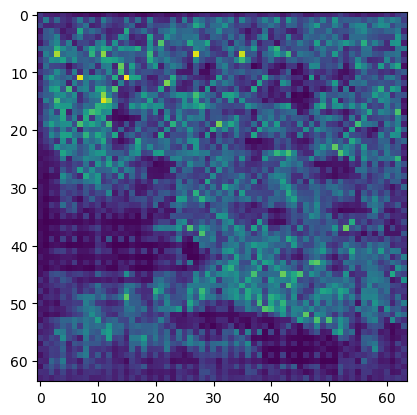

In [38]:
# denormalise generated map

generated_map *= 255

generated_map = generated_map.numpy()

generated_map = np.reshape(generated_map, (64,64))

generated_map = np.round(generated_map,0)
print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',', fmt='%i')

generated_map = generated_map.tolist()


plt.imshow(generated_map)

# Graphs:

Losses

Text(0.5, 0, 'Epoch')

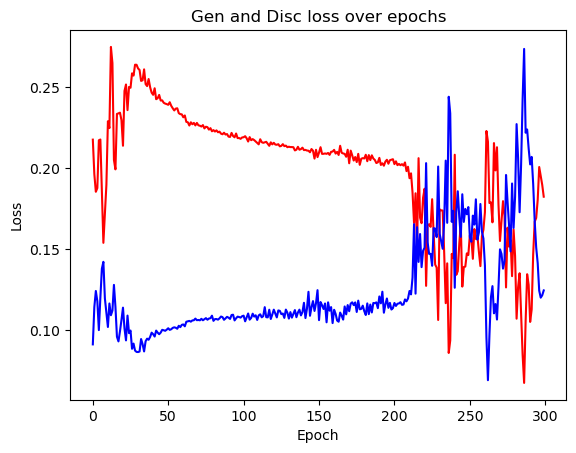

In [39]:
epoch_list = [i for i in range(0,N_EPOCHS)]


plt.plot(epoch_list, disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Discriminator Accuracy

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4800,) + inhomogeneous part.

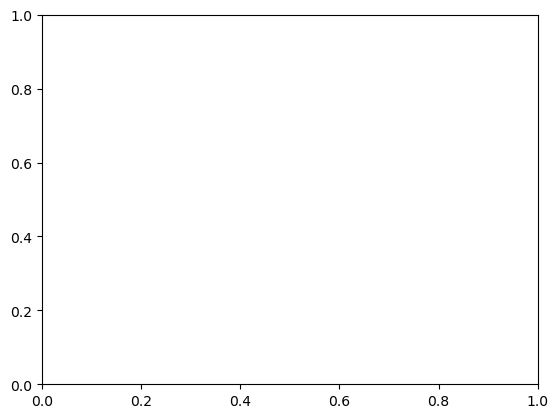

In [40]:
plt.plot(epoch_list, disc_accuracies,  'r-')

plt.title('Disc accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')